IMPORTANT: submissions in test set should be different from train set, i.e., `train_test_different_submissions = True`

In [1]:
CONFIG_PATH = "configs/finetune_CURIO_test_diff.yml"
from utils import get_config
config = get_config(CONFIG_PATH, "_sim", print_config = False)
peer_vote_option = "real" # "real", "real_user_same_vote", "similar_user_same_vote", "real_user_opposite_vote", "similar_user_opposite_vote"
from superdebug import debug
debug(peer_vote_option=peer_vote_option)
use_voted_users_feature = config["use_voted_users_feature"]
use_voted_users_feature = False
if use_voted_users_feature:
    print("Use peer votes as model input feature")
else:
    print("Finetune the model using peer votes")

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-10-24 16:05:13 ------------------
GPU ready...
Smart using cuda:3
------------------ 2022-10-24 16:05:14 ------------------
DEBUG: 1 vars: ['peer_vote_option'], at <ipython-input-1-1b7eb2607882>:6 <module>
0 / 1.  peer_vote_option str len 4: real
------------------ 2022-10-24 16:05:14 ------------------
Finetune the model using peer votes


In [2]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
import torch
from process_data import get_model_input
from model import get_best_model, TransformerVoter
from utils import get_user_reps, get_bool_vec, record_existing_votes
from train import evaluate_model, train_model
import sklearn.metrics
import copy

Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


In [3]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)

------------------ 2022-10-24 16:05:20 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:364 get_model_input
Loading prepared data...
------------------ 2022-10-24 16:05:20 ------------------


In [4]:
model, _ = get_best_model(config, categorical_features, string_features, original_feature_map)

------------------ 2022-10-24 16:05:22 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:251 get_tokenizer
0 / 2.  original_token_num num val: 30522
------------------ 2022-10-24 16:05:22 ------------------
------------------ 2022-10-24 16:05:22 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:263 get_tokenizer
0 / 3.  latest_token_num num val: 30576
------------------ 2022-10-24 16:05:22 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
print(model.device)
test_data.iloc[:2]
# !nvidia-smi

cuda:3


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,group_id,TITLE,author_id,AUTHOR,NSFW,LINK,timestamp,#_COMMENTS,SUBMISSION_TEXT,SUBMISSION_URL
0,62e3007451803b00160f2bd1,r/Team Mignon,Thu Jul 28 2022,2,0.0,62d1ccae5631c64c66b3c4c3,I think it's less the number of years of free ...,62d6fb4c84f3b100160e615c,14,false,,1.659044e+09,0,,
1,62fd4c8b0804680016acda57,r/LOLCHI,Wed Aug 17 2022,15,0.0,619c6bb8762f45190c34df31,"He's doing his best to minimize self-cites, wh...",62fabdaf73e60a001685c0fe,10,false,,1.660767e+09,0,,


Define functions to simulate new peer votes

In [6]:
def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.at[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    peer_votes_num_acc_df.at[peer_vote_num, "Acc"] += int(pred_target_vote == target_vote)
    peer_votes_num_acc_df.at[peer_vote_num, "Confidence"] += abs(1- target_vote - pred_target_vote_score)
        
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.at[peer_vote_num, "Same as majority"] += 1

def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_data.at[0, "UPVOTED_USERS"] = upvoted_users
        target_vote_data.at[0, "DOWNVOTED_USERS"] = downvoted_users
        pred_target_vote_score = evaluate_model(config, model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, data=peer_votes_data, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, step_generator=True, n_step_per_sample=n_step_per_sample, extra_input = extra_input)):
            if tmp_model is None:
                print("tmp_model is", tmp_model)
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [7]:
n_step_per_sample = 1
if not use_voted_users_feature:
    model.optim = torch.optim.Adam(model.parameters(), lr = 1.2 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 1

In [8]:
if peer_vote_option == "similar_user_opposite_vote" or peer_vote_option == "similar_user_same_vote":
    existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes, existing_user_subreddits = record_existing_votes(train_data)

    all_users = list(range(max(max(train_data["USERNAME"]), max(test_data["USERNAME"])) + 1))
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    all_users_reps, all_user_i_user_map = get_user_reps(all_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = {key: None for key in set(train_data["SUBMISSION_ID"])}, user_grouping_method = "votes", do_PCA = False)

    user_similarity = sklearn.metrics.pairwise.cosine_similarity(all_users_reps)


Simulate new votes coming and calculate the accuracy

In [9]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
max_voted_users = 1000
xlim = 50
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,4)), columns=['Acc', 'Confidence', 'Total', "Same as majority"])
model = model.to(model.device)
assert len(peer_votes_num_acc_df) == 1001

In [10]:
peer_votes_num_acc_df

,Acc,Confidence,Total,Same as majority
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
996,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0
999,0.0,0.0,0.0,0.0


In [11]:
# test_data["UPVOTED_USERS"] = test_data["UPVOTED_USERS"].astype('object')
# test_data["DOWNVOTED_USERS"] = test_data["DOWNVOTED_USERS"].astype('object')

for submission_id in tqdm(test_submissions[0:2000]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    target_vote_data = submission_votes_data.iloc[-1:].reset_index(drop=True)
    target_vote = int(target_vote_data["VOTE"])
    peer_votes_data = submission_votes_data.iloc[:-1]
    # peer_votes_data = peer_votes_data[:xlim]
    if peer_vote_option == "real":
        pass
    elif peer_vote_option == "real_user_opposite_vote":
        peer_votes_data.loc[:,"VOTE"] = [1 - target_vote] * len(peer_votes_data)
    elif peer_vote_option == "real_user_same_vote":
        peer_votes_data.loc[:,"VOTE"] = [target_vote] * len(peer_votes_data)
    elif peer_vote_option == "similar_user_opposite_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [1 - target_vote] * xlim
    elif peer_vote_option == "similar_user_same_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:xlim]
        peer_votes_data = pd.concat([target_vote_data] * xlim, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [target_vote] * xlim
    
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    # print(peer_votes_num_acc_df)
        

  1%|▏         | 1/76 [00:00<00:28,  2.61it/s]

tmp_model is None


  3%|▎         | 2/76 [00:01<01:06,  1.12it/s]

tmp_model is None


  4%|▍         | 3/76 [00:01<00:46,  1.57it/s]

tmp_model is None


  5%|▌         | 4/76 [00:03<00:57,  1.25it/s]

tmp_model is None


  7%|▋         | 5/76 [00:03<01:00,  1.17it/s]

tmp_model is None


  8%|▊         | 6/76 [00:04<01:01,  1.14it/s]

tmp_model is None


  9%|▉         | 7/76 [00:06<01:13,  1.06s/it]

tmp_model is None


 11%|█         | 8/76 [00:06<00:57,  1.18it/s]

tmp_model is None


 12%|█▏        | 9/76 [00:07<01:03,  1.06it/s]

tmp_model is None


 13%|█▎        | 10/76 [00:08<00:51,  1.27it/s]

tmp_model is None


 14%|█▍        | 11/76 [00:09<00:53,  1.22it/s]

tmp_model is None


 16%|█▌        | 12/76 [00:09<00:43,  1.49it/s]

tmp_model is None


 17%|█▋        | 13/76 [00:09<00:37,  1.66it/s]

tmp_model is None


 18%|█▊        | 14/76 [00:10<00:44,  1.39it/s]

tmp_model is None


 20%|█▉        | 15/76 [00:11<00:38,  1.57it/s]

tmp_model is None


 21%|██        | 16/76 [00:11<00:32,  1.84it/s]

tmp_model is None


 22%|██▏       | 17/76 [00:12<00:30,  1.95it/s]

tmp_model is None


 24%|██▎       | 18/76 [00:12<00:28,  2.04it/s]

tmp_model is None


 25%|██▌       | 19/76 [00:12<00:25,  2.27it/s]

tmp_model is None


 26%|██▋       | 20/76 [00:13<00:31,  1.75it/s]

tmp_model is None


 28%|██▊       | 21/76 [00:15<00:41,  1.31it/s]

tmp_model is None


 29%|██▉       | 22/76 [00:16<00:48,  1.11it/s]

tmp_model is None


 30%|███       | 23/76 [00:16<00:38,  1.37it/s]

tmp_model is None


 32%|███▏      | 24/76 [00:17<00:43,  1.18it/s]

tmp_model is None


 33%|███▎      | 25/76 [00:18<00:47,  1.08it/s]

tmp_model is None


 34%|███▍      | 26/76 [00:19<00:37,  1.34it/s]

tmp_model is None


 36%|███▌      | 27/76 [00:19<00:32,  1.52it/s]

tmp_model is None


 37%|███▋      | 28/76 [00:20<00:28,  1.69it/s]

tmp_model is None


 38%|███▊      | 29/76 [00:20<00:31,  1.48it/s]

tmp_model is None


 39%|███▉      | 30/76 [00:21<00:26,  1.75it/s]

tmp_model is None


 41%|████      | 31/76 [00:22<00:30,  1.48it/s]

tmp_model is None


 42%|████▏     | 32/76 [00:22<00:26,  1.65it/s]

tmp_model is None


 43%|████▎     | 33/76 [00:22<00:22,  1.92it/s]

tmp_model is None


 45%|████▍     | 34/76 [00:23<00:20,  2.01it/s]

tmp_model is None


 46%|████▌     | 35/76 [00:23<00:19,  2.08it/s]

tmp_model is None


 47%|████▋     | 36/76 [00:24<00:18,  2.11it/s]

tmp_model is None


 49%|████▊     | 37/76 [00:25<00:23,  1.63it/s]

tmp_model is None


 50%|█████     | 38/76 [00:25<00:20,  1.90it/s]

tmp_model is None


 51%|█████▏    | 39/76 [00:25<00:17,  2.13it/s]

tmp_model is None


 53%|█████▎    | 40/76 [00:26<00:21,  1.69it/s]

tmp_model is None


 54%|█████▍    | 41/76 [00:27<00:25,  1.36it/s]

tmp_model is None


 55%|█████▌    | 42/76 [00:28<00:28,  1.18it/s]

tmp_model is None


 57%|█████▋    | 43/76 [00:29<00:23,  1.38it/s]

tmp_model is None


 58%|█████▊    | 44/76 [00:30<00:25,  1.25it/s]

tmp_model is None


 59%|█████▉    | 45/76 [00:31<00:26,  1.18it/s]

tmp_model is None


 61%|██████    | 46/76 [00:32<00:28,  1.04it/s]

tmp_model is None


 62%|██████▏   | 47/76 [00:33<00:27,  1.05it/s]

tmp_model is None


 63%|██████▎   | 48/76 [00:34<00:28,  1.00s/it]

tmp_model is None


 64%|██████▍   | 49/76 [00:34<00:21,  1.25it/s]

tmp_model is None


 66%|██████▌   | 50/76 [00:35<00:21,  1.21it/s]

tmp_model is None


 67%|██████▋   | 51/76 [00:36<00:16,  1.49it/s]

tmp_model is None


 68%|██████▊   | 52/76 [00:36<00:13,  1.75it/s]

tmp_model is None


 70%|██████▉   | 53/76 [00:37<00:17,  1.31it/s]

tmp_model is None


 71%|███████   | 54/76 [00:38<00:18,  1.16it/s]

tmp_model is None


 72%|███████▏  | 55/76 [00:39<00:14,  1.43it/s]

tmp_model is None


 74%|███████▎  | 56/76 [00:39<00:11,  1.70it/s]

tmp_model is None


 75%|███████▌  | 57/76 [00:40<00:13,  1.43it/s]

tmp_model is None


 76%|███████▋  | 58/76 [00:40<00:11,  1.61it/s]

tmp_model is None


 78%|███████▊  | 59/76 [00:41<00:09,  1.76it/s]

tmp_model is None


 79%|███████▉  | 60/76 [00:42<00:11,  1.40it/s]

tmp_model is None


 80%|████████  | 61/76 [00:42<00:09,  1.57it/s]

tmp_model is None


 82%|████████▏ | 62/76 [00:43<00:07,  1.82it/s]

tmp_model is None


 83%|████████▎ | 63/76 [00:43<00:06,  2.07it/s]

tmp_model is None


 84%|████████▍ | 64/76 [00:43<00:05,  2.11it/s]

tmp_model is None


 86%|████████▌ | 65/76 [00:44<00:07,  1.56it/s]

tmp_model is None


 87%|████████▋ | 66/76 [00:45<00:06,  1.65it/s]

tmp_model is None


 88%|████████▊ | 67/76 [00:45<00:05,  1.76it/s]

tmp_model is None


 89%|████████▉ | 68/76 [00:46<00:03,  2.01it/s]

tmp_model is None


 91%|█████████ | 69/76 [00:46<00:03,  2.08it/s]

tmp_model is None


 92%|█████████▏| 70/76 [00:47<00:03,  1.59it/s]

tmp_model is None


 93%|█████████▎| 71/76 [00:48<00:03,  1.36it/s]

tmp_model is None


 95%|█████████▍| 72/76 [00:49<00:03,  1.20it/s]

tmp_model is None


 96%|█████████▌| 73/76 [00:50<00:02,  1.07it/s]

tmp_model is None


 97%|█████████▋| 74/76 [00:52<00:02,  1.01s/it]

tmp_model is None


 99%|█████████▊| 75/76 [00:52<00:00,  1.18it/s]

tmp_model is None


100%|██████████| 76/76 [00:52<00:00,  1.44it/s]

tmp_model is None


In [12]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Accuracy"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Confidence"] = peer_votes_num_acc_df["Confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

/home/TableSense/anaconda3/envs/cr4/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/TableSense/anaconda3/envs/cr4/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/TableSense/anaconda3/envs/cr4/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Acc,Confidence,Total,Same as majority,Accuracy,Same as majority rate,Total scaled
0,54.0,0.704521,76.0,0.0,0.710526,0.000000,1.000000
1,55.0,0.705271,76.0,41.0,0.723684,0.539474,1.000000
2,57.0,0.714322,76.0,33.0,0.750000,0.434211,1.000000
3,55.0,0.732842,76.0,54.0,0.723684,0.710526,1.000000
4,60.0,0.745499,76.0,57.0,0.789474,0.750000,1.000000
5,57.0,0.752187,76.0,65.0,0.750000,0.855263,1.000000
6,40.0,0.730781,55.0,47.0,0.727273,0.854545,0.723684
7,41.0,0.734224,54.0,49.0,0.759259,0.907407,0.710526
8,29.0,0.811898,35.0,32.0,0.828571,0.914286,0.460526
9,28.0,0.824407,35.0,33.0,0.800000,0.942857,0.460526


------------------ 2022-10-24 16:06:29 ------------------
DEBUG: at <ipython-input-13-754ebc79e6f7>:6 <module>
Confidence and accuracy
------------------ 2022-10-24 16:06:29 ------------------


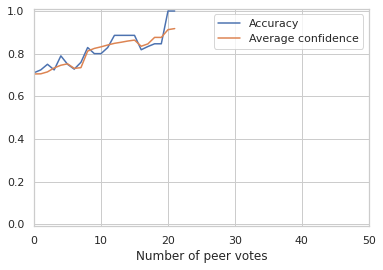

In [13]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns
from matplotlib import pyplot as plt
peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:xlim]
debug("Confidence and accuracy")
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Accuracy', label = "Accuracy")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Confidence', label = "Average confidence")
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.legend(loc='upper right')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
plt.xlabel("Number of peer votes")
plt.ylabel("")
plt.show()

Text(0.5, 0, 'Number of peer votes')

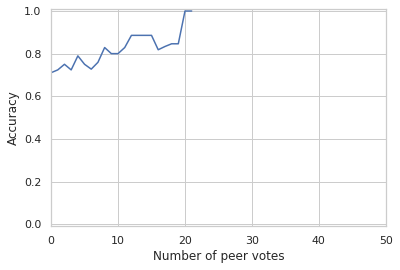

In [14]:
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Accuracy')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
plt.xlabel("Number of peer votes")

------------------ 2022-10-24 16:06:31 ------------------
DEBUG: at <ipython-input-15-f4e2ca066c58>:1 <module>
Same as majority rate
------------------ 2022-10-24 16:06:31 ------------------


Text(0.5, 0, 'Number of peer votes')

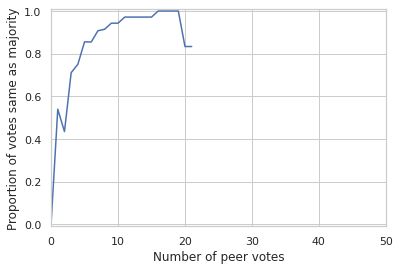

In [15]:
debug("Same as majority rate")
ax = sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
# sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, xlim])
ax.set_ylabel("Proportion of votes same as majority")
plt.xlabel("Number of peer votes")

In [16]:
peer_votes_num_acc_df_part["Confidence"]

0     0.704521
1     0.705271
2     0.714322
3     0.732842
4     0.745499
5     0.752187
6     0.730781
7     0.734224
8     0.811898
9     0.824407
10    0.831898
11    0.840483
12    0.848285
13    0.853363
14    0.859117
15    0.863464
16    0.834637
17    0.845748
18    0.876182
19    0.876035
20    0.912417
21    0.917482
Name: Confidence, dtype: float64